In [ ]:
#!pip freeze > requirements.txt
#!pip install -r requirements.txt
#!pip install "urllib3<2" # Warning
#%pip install "pytorch==1.10.1"
#%pip install transformers datasets tensorboard --upgrade
#!sudo apt-get install git-lfs
#!brew install git-lfs

# Help Functions

### Training Evaluation metrics

In [1]:
from evaluate import load
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Load the accuracy metric
accuracy_metric = load("accuracy")
precision_metric = load("precision")
recall_metric = load("recall")
f1_metric = load("f1")

all_metrics = []

def compute_metrics(eval_pred):
    global all_metrics

    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average="macro", zero_division=0)
    recall = recall_score(labels, predictions, average="macro", zero_division=0)
    f1 = f1_score(labels, predictions, average="macro", zero_division=0)
    #return {
    #    "accuracy": acc,#["accuracy"],
    #    "precision": precision,#["precision"],
    #    "recall": recall,#["recall"],
    #    "f1": f1,#["f1"]
    #}
    # Save the metrics in the global list (add a dictionary with metrics)
    metrics = {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }
    # Append the metrics to the list
    all_metrics.append(metrics)
    return metrics

### Final Model Evaluation

In [2]:
#!pip install evaluate

from evaluate import evaluator
from transformers import pipeline

task_evaluator = evaluator("text-classification")

def evaluate_model(model, tokenizer, data):
    model_eval = task_evaluator.compute(
        model_or_pipeline=model,
        tokenizer=tokenizer,
        data=data,
        input_column="sentence",
        label_column="label",
        label_mapping={"negative": 0, "positive": 1}
    )

    return model_eval

### Training Visualization

In [3]:
import matplotlib.pyplot as plt

def plot_train_eval_metrics(trainer, all_metrics):    
    # Get the training and validation losses
    train_losses = trainer.state.log_history

    # Extracting training and validation loss
    train_loss_values = [log['loss'] for log in train_losses if 'loss' in log]
    eval_loss_values = [log['eval_loss'] for log in train_losses if 'eval_loss' in log]

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # Create two subplots side by side

    # Plot the loss on the first axis (Train and Validation Loss)
    axes[0].plot(train_loss_values, label='Train Loss', color='tab:blue')
    axes[0].plot(eval_loss_values, label='Validation Loss', color='tab:orange')

    # Mark the best epoch for train and validation losses (minimum loss)
    best_train_epoch = train_loss_values.index(min(train_loss_values))
    best_eval_epoch = eval_loss_values.index(min(eval_loss_values))

    # Mark the best epochs with points
    axes[0].scatter(best_train_epoch, train_loss_values[best_train_epoch], color='tab:blue', zorder=5)
    axes[0].scatter(best_eval_epoch, eval_loss_values[best_eval_epoch], color='tab:orange', zorder=5)

    axes[0].set_title('Train and Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Define the plotting function for all metrics on one graph (with best epoch marked)
    def plot_all_metrics_on_one_graph(all_metrics, ax):
        # Extract each metric from the all_metrics list
        accuracy = [metrics["accuracy"] for metrics in all_metrics]
        precision = [metrics["precision"] for metrics in all_metrics]
        recall = [metrics["recall"] for metrics in all_metrics]
        f1 = [metrics["f1"] for metrics in all_metrics]

        # Plot all metrics on the same axis without points (just lines)
        ax.plot(accuracy, label='Accuracy', color='tab:blue')
        ax.plot(precision, label='Precision', color='tab:green')
        ax.plot(recall, label='Recall', color='tab:red')
        ax.plot(f1, label='F1 Score', color='tab:purple')

        # Mark the best epoch for each metric with a point (max value)
        best_accuracy_epoch = accuracy.index(max(accuracy))
        best_precision_epoch = precision.index(max(precision))
        best_recall_epoch = recall.index(max(recall))
        best_f1_epoch = f1.index(max(f1))

        # Mark the best epochs with points
        ax.scatter(best_accuracy_epoch, accuracy[best_accuracy_epoch], color='tab:blue', zorder=5)
        ax.scatter(best_precision_epoch, precision[best_precision_epoch], color='tab:green', zorder=5)
        ax.scatter(best_recall_epoch, recall[best_recall_epoch], color='tab:red', zorder=5)
        ax.scatter(best_f1_epoch, f1[best_f1_epoch], color='tab:purple', zorder=5)

        # Add title and labels
        ax.set_title('Evaluation Metrics Over Epochs')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Metric Value')

        # Show legend
        ax.legend()

    # Create the second plot for all metrics with best epochs marked
    plot_all_metrics_on_one_graph(all_metrics, axes[1])

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

### Load Local model

In [4]:
from transformers import BertConfig

def load_local_model(model_path: str, set_size=False):
    # Load the configuration for the model
    model_config = BertConfig.from_pretrained(f"{model_path}/config.json")

    if set_size == True:
        model_config.hidden_size = 384
        model_config.intermediate_size = 1536
        
    model = AutoModelForSequenceClassification.from_pretrained(
        model_path,
        config=model_config,
        local_files_only=True,
        ignore_mismatched_sizes=True,
        )
    
    return model

### Load Dataset and Tokenizer

In [5]:
from transformers import AutoTokenizer
from datasets import load_dataset

#main_model = "google-bert/bert-base-uncased"
main_model = "textattack/bert-base-uncased-SST-2"
tiny_bert_id = "google/bert_uncased_L-2_H-128_A-2"
teacher_id = main_model # The main model will also be our teacher for model distillation

tokenizer = AutoTokenizer.from_pretrained(main_model) # We use the same tokenizer throughout all models. It becomes more important for distilliation

dataset_id="glue"
dataset_config="sst2"

dataset = load_dataset(dataset_id,dataset_config)
#dataset = load_dataset("SetFit/sst2")
dataset

def process(examples):
    tokenized_inputs = tokenizer(
        examples["sentence"], truncation=True, max_length=512
        #examples["text"], truncation=True, max_length=512
    )
    return tokenized_inputs

tokenized_datasets = dataset.map(process, batched=True)
tokenized_datasets = tokenized_datasets.rename_column("label","labels")
tokenized_datasets["train"] = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))

#tokenized_datasets["test"].features

### Load External Bert Model

In [6]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false" # Warning
import torch
from transformers import AutoModelForSequenceClassification, DataCollatorWithPadding
from huggingface_hub import HfFolder

# create label2id, id2label dicts for nice outputs for the model
labels = tokenized_datasets["train"].features["labels"].names
#labels = ["negative", "positive"]
num_labels = len(labels)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

def load_external_model(model_id: str):
    model = AutoModelForSequenceClassification.from_pretrained(
        model_id,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id
    )
    return model

# Structural Pruning

https://github.com/VainF/Torch-Pruning

In [7]:
#!pip install torch-pruning
from transformers import AutoTokenizer, BertModel, BertForSequenceClassification
import torch
from transformers.models.bert.modeling_bert import BertSelfAttention, BertPooler
import torch_pruning as tp

pruned_model = load_external_model(main_model)

hf_inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
example_inputs = {'input_ids': hf_inputs['input_ids'], 'token_type_ids': hf_inputs['token_type_ids'], 'attention_mask': hf_inputs['attention_mask']}

imp = tp.importance.MagnitudeImportance(p=2, group_reduction="mean")
base_macs, base_params = tp.utils.count_ops_and_params(pruned_model, example_inputs)
num_heads = {}

# All heads should be pruned simultaneously, so we group channels by head.
for m in pruned_model.modules():
    if isinstance(m, BertSelfAttention):
        num_heads[m.query] = m.num_attention_heads
        num_heads[m.key] = m.num_attention_heads
        num_heads[m.value] = m.num_attention_heads

# https://github.com/VainF/Torch-Pruning/blob/master/torch_pruning/pruner/algorithms/metapruner.py
pruner = tp.pruner.MetaPruner(
    pruned_model, 
    example_inputs, 
    global_pruning=False, # If False, a uniform pruning ratio will be assigned to different layers.
    importance=imp, # importance criterion for parameter selection
    iterative_steps=1, # the number of iterations to achieve target pruning ratio
    pruning_ratio=0.5,
    num_heads=num_heads,
    prune_head_dims=False,
    prune_num_heads=True,
    head_pruning_ratio=0.5,
    output_transform=lambda out: out.logits.sum(),
    ignored_layers=[pruned_model.bert.pooler],
)

for g in pruner.step(interactive=True):
    #print(g)
    g.prune()

# Modify the attention head size and all head size after pruning
for m in pruned_model.modules():
    if isinstance(m, BertSelfAttention):
        #print("Num heads: %d, head size: %d =>"%(m.num_attention_heads, m.attention_head_size))
        m.num_attention_heads = pruner.num_heads[m.query]
        m.attention_head_size = m.query.out_features // m.num_attention_heads
        m.all_head_size = m.query.out_features
        #print("Num heads: %d, head size: %d"%(m.num_attention_heads, m.attention_head_size))
        #print()
        
for m in pruned_model.modules():
    if isinstance(m, BertPooler):
        m.dense = torch.nn.Linear(384, 384)  # Modify the pooler layer to use 384 input/output features
        print(f"Modified pooler dense layer to in_features=384, out_features=384")

for m in pruned_model.modules():
    if isinstance(m, BertForSequenceClassification):
        m.classifier = torch.nn.Linear(384, 2)  # Modify classifier to match the new pooler output size
        print(f"Modified classifier output to {m.classifier.out_features}")

#print(pruned_model)

test_output = pruned_model(**example_inputs)
pruned_macs, pruned_params = tp.utils.count_ops_and_params(pruned_model, example_inputs)
print("Base MACs: %f M, Pruned MACs: %f M"%(base_macs/1e6, pruned_macs/1e6))
print("Base Params: %f M, Pruned Params: %f M"%(base_params/1e6, pruned_params/1e6))

# Calculate the difference in parameters before and after pruning
params_diff = base_params - pruned_params

# Print the comparison
print("Difference in Params: %f M"%(params_diff/1e6))

Warning! No positional inputs found for a module, assuming batch size is 1.
Modified pooler dense layer to in_features=384, out_features=384
Modified classifier output to 2
Warning! No positional inputs found for a module, assuming batch size is 1.
Base MACs: 680.459522 M, Pruned MACs: 170.212994 M
Base Params: 109.483778 M, Pruned Params: 33.360770 M
Difference in Params: 76.123008 M


# Training Variables

In [8]:
# Folder for checkpoints and logs during training
output_dir = "training_temp"
num_train_epochs = 10
per_device_train_batch_size = 64
per_device_eval_batch_size = 64
fp16=False
learning_rate=3e-5
seed=33
logging_dir=f'{output_dir}/logs'
logging_strategy="epoch"
evaluation_strategy="epoch"
save_strategy="epoch"
save_total_limit=3 # How many tempory checkpoints should be saved
load_best_model_at_end=True
metric_for_best_model="accuracy"
greater_is_better=True,
#metric_for_best_model="eval_loss",  # Monitor validation loss
#greater_is_better=False, # For validation loss, less is better
weight_decay=0.5 # Not set in the training examples
early_stopping_patience=3

# Basic Training

In [9]:
# Evalutation METRICS
#%pip install evaluate
#%pip install scikit-learn
from transformers import AutoTokenizer, BertModel, BertForSequenceClassification, EarlyStoppingCallback
import torch
from transformers.models.bert.modeling_bert import BertSelfAttention, BertPooler
import torch_pruning as tp
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    per_device_eval_batch_size=per_device_eval_batch_size,
    fp16=fp16,
    learning_rate=learning_rate,
    seed=seed,
    # logging & evaluation strategies
    logging_dir=logging_dir,
    logging_strategy=logging_strategy, # to get more information to TB
    evaluation_strategy=evaluation_strategy,
    save_strategy=save_strategy,
    save_total_limit=save_total_limit,
    load_best_model_at_end=load_best_model_at_end,
    metric_for_best_model=metric_for_best_model,
    greater_is_better=greater_is_better,
    #weight_decay=weight_decay
)

# define data_collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

early_stopping = EarlyStoppingCallback(early_stopping_patience=early_stopping_patience)

# One Trainer for the pruned_model
prune_trainer = Trainer (
    pruned_model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

tiny_bert_model = load_external_model(tiny_bert_id)

# One Trainer for the tiny_bert_model
tiny_bert_trainer = Trainer (
    tiny_bert_model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

/Users/christophknaden/venv/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/mv/96db_j8j3ng3t9pc8jczncdh0000gn/T/ipykernel_5582/3483896654.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  prune_trainer = Trainer (
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-2_H-128_A-2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/mv/96db_j8j3ng3t9pc8jczncdh0000gn/T/ipykernel_5582/3483896654.py:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_clas

In [10]:
# Pruned model path without training
pruned_model_path = "./pruned_model"

In [ ]:
# Save pruned model without training, as base for distillation
prune_trainer.save_model(pruned_model_path)

In [61]:
pruned_model_loaded = load_local_model(pruned_model_path, set_size=True)

## Train pruned model & Tiny Bert conventional way

#### Pruned Model

In [12]:
# Train a pruned model the conventional way
prune_trainer.train()

# Save metrics
all_metrics_pruned = all_metrics

all_metrics = []

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.685900,0.694223,0.509174,0.254587,0.500000,0.337386
2,0.678000,0.698425,0.516055,0.550681,0.507599,0.378703
3,0.671600,0.692129,0.516055,0.531147,0.521239,0.477102
4,0.657600,0.679751,0.581422,0.582306,0.582018,0.581223
5,0.633900,0.666168,0.557339,0.595729,0.562747,0.518384
6,0.604000,0.645530,0.596330,0.643274,0.601330,0.566708
7,0.576800,0.604949,0.669725,0.689288,0.672518,0.663131
8,0.539100,0.583251,0.696101,0.696004,0.696020,0.696011
9,0.512300,0.619890,0.670872,0.690550,0.667751,0.659552
10,0.488200,0.578149,0.702982,0.704368,0.702061,0.701795


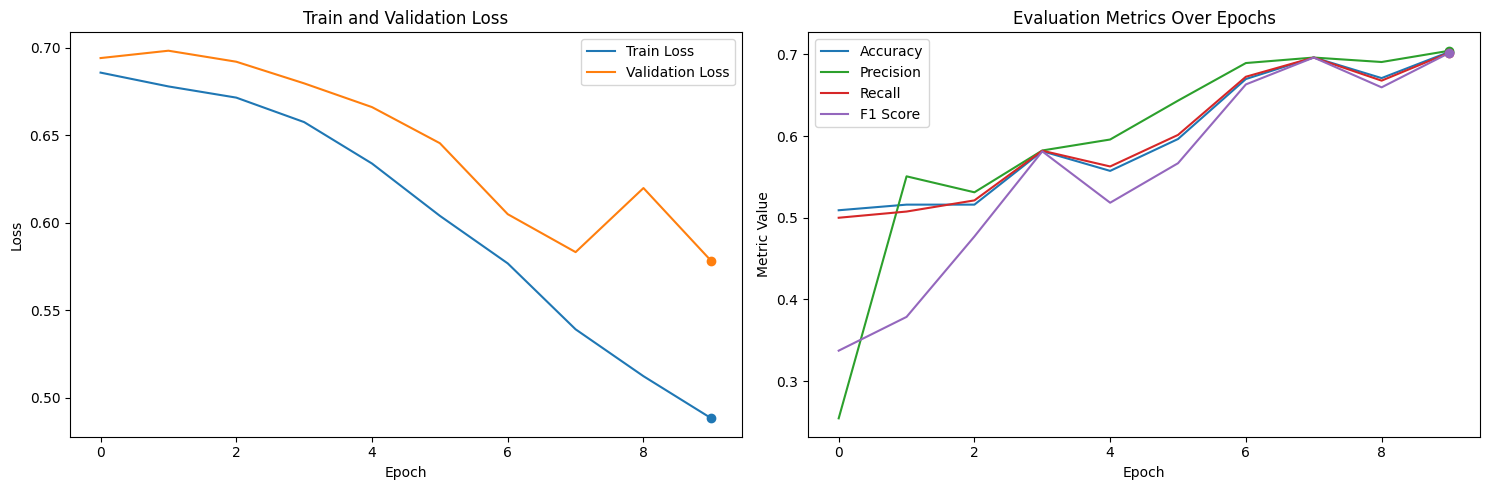

In [13]:
plot_train_eval_metrics(prune_trainer, all_metrics_pruned)

In [14]:
# Pruned model path with training
pruned_model_trained_path = "./pruned_model_trained"

In [ ]:
# Save pruned model with training
prune_trainer.save_model(pruned_model_trained_path)

In [15]:
pruned_model_trained = load_local_model(pruned_model_trained_path, set_size=True)

#### Tiny Bert

In [16]:
# Train a pruned model the conventional way
tiny_bert_trainer.train()

# Save metrics
all_metrics_tiny_bert = all_metrics

all_metrics = []

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.689100,0.699945,0.509174,0.254587,0.500000,0.337386
2,0.684900,0.695120,0.509174,0.504598,0.500042,0.339464
3,0.682400,0.691946,0.521789,0.609840,0.513187,0.380005
4,0.678900,0.689011,0.525229,0.545404,0.518123,0.436513
5,0.673800,0.686411,0.543578,0.568570,0.537404,0.481371
6,0.669200,0.683724,0.556193,0.570945,0.551391,0.520794
7,0.667200,0.681728,0.567661,0.578091,0.563747,0.544902
8,0.668200,0.680260,0.579128,0.584161,0.576356,0.567829
9,0.661500,0.679353,0.580275,0.583260,0.577987,0.572446
10,0.660200,0.679022,0.579128,0.581510,0.576987,0.572196


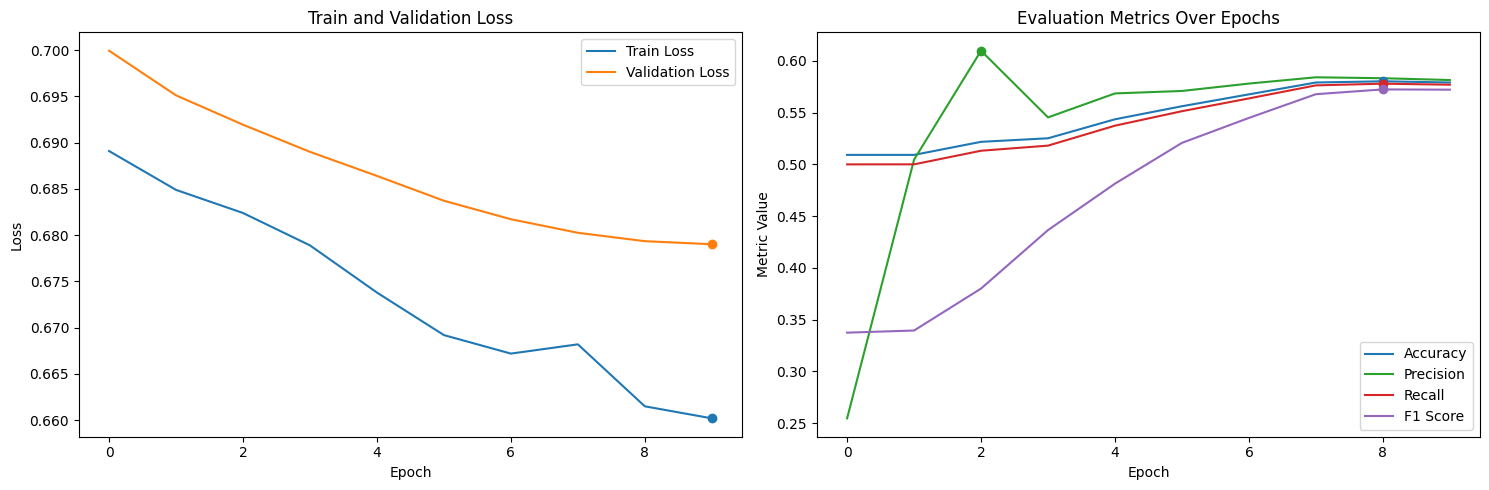

In [17]:
plot_train_eval_metrics(tiny_bert_trainer, all_metrics_tiny_bert)

In [18]:
# Pruned model path with training
tiny_bert_model_trained_path = "./tiny_bert_model_trained"

In [20]:
# Save pruned model with training
tiny_bert_trainer.save_model(tiny_bert_model_trained_path)

In [21]:
tiny_bert_model_trained = load_local_model(tiny_bert_model_trained_path)

# Knowledge Distillation


https://github.com/philschmid/knowledge-distillation-transformers-pytorch-sagemaker/tree/master

In [25]:
from huggingface_hub import login

repo_name = "sst2-distillation" # set name for repository on huggingface

#login()
#

In [26]:
%%writefile custom_args.py
# Write class to external class to work
from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

Overwriting custom_args.py


In [27]:
#%pip install torch torchvision torchaudio
import importlib
import custom_args
importlib.reload(custom_args)
from custom_args import DistillationTrainingArguments
from transformers import TrainingArguments, Trainer
import torch
import torch.nn as nn
import torch.nn.functional as F

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, accelerator=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher = teacher_model

        self.accelerator = accelerator if accelerator else Accelerator()
        # Place teacher model on the correct device using the accelerator
        self.teacher = self.accelerator.prepare(self.teacher)
        
        # place teacher on same device as student
        #self._move_model_to_device(self.teacher,self.model.device)
        self.teacher.eval()

def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
    # compute student output
    outputs_student = model(**inputs)
    student_loss = outputs_student.loss

    # compute teacher output
    with torch.no_grad():
        outputs_teacher = self.teacher(**inputs)

    # assert size
    assert outputs_student.logits.size() == outputs_teacher.logits.size()

    # Soften probabilities and compute distillation loss
    loss_function = nn.KLDivLoss(reduction="batchmean")
    loss_logits = (loss_function(
        F.log_softmax(outputs_student.logits / self.args.temperature, dim=-1),
        F.softmax(outputs_teacher.logits / self.args.temperature, dim=-1)) * (self.args.temperature ** 2))

    # Return weighted student loss
    loss = self.args.alpha * student_loss + (1. - self.args.alpha) * loss_logits
    return (loss, outputs_student) if return_outputs else loss


### Hyperparameter Definition, Model Loading

In [28]:
#%pip install transformers[torch]
#%pip install "accelerate==1.2.1"
from transformers import DataCollatorWithPadding
from huggingface_hub import HfFolder

# define training args
training_args = DistillationTrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    per_device_eval_batch_size=per_device_eval_batch_size,
    fp16=fp16,
    learning_rate=learning_rate,
    seed=seed,
    # logging & evaluation strategies
    logging_dir=f"{output_dir}/logs",
    logging_strategy=logging_strategy,
    evaluation_strategy=evaluation_strategy,
    save_strategy=save_strategy,
    save_total_limit=save_total_limit,
    load_best_model_at_end=load_best_model_at_end,
    metric_for_best_model=metric_for_best_model,
    greater_is_better=greater_is_better,
    # special parameters for huggingface
    report_to="tensorboard",
    # push to hub parameters
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=repo_name,
    hub_token=HfFolder.get_token(),
    # distilation parameters
    alpha=0.5,
    temperature=4.0
    )

# define data_collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

early_stopping = EarlyStoppingCallback(early_stopping_patience=early_stopping_patience)

teacher_model = load_external_model(teacher_id)

/Users/christophknaden/venv/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [29]:
from accelerate import Accelerator
accelerator = Accelerator(cpu=True)

## Train pruned model & Tiny Bert with Distillation

In [62]:
# train pruned_model_trained with distillation
distilliation_trainer_pruned = DistillationTrainer(
    pruned_model_loaded,
    training_args,
    teacher_model=teacher_model,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    accelerator=accelerator,
    callbacks=[early_stopping]
)

tiny_bert_model = load_external_model(tiny_bert_id)

distilliation_trainer_tiny_bert = DistillationTrainer(
    tiny_bert_model,
    training_args,
    teacher_model=teacher_model,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    accelerator=accelerator,
    callbacks=[early_stopping]
)

/var/folders/mv/96db_j8j3ng3t9pc8jczncdh0000gn/T/ipykernel_5582/239319299.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-2_H-128_A-2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Pruned Model

In [63]:
distilliation_trainer_pruned.train()

# save metrics
all_metrics_pruned_distilled = all_metrics

all_metrics = []

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.702100,0.698604,0.509174,0.254587,0.500000,0.337386
2,0.694400,0.699589,0.509174,0.254587,0.500000,0.337386
3,0.679600,0.681903,0.509174,0.254587,0.500000,0.337386
4,0.700700,0.694717,0.490826,0.245413,0.500000,0.329231


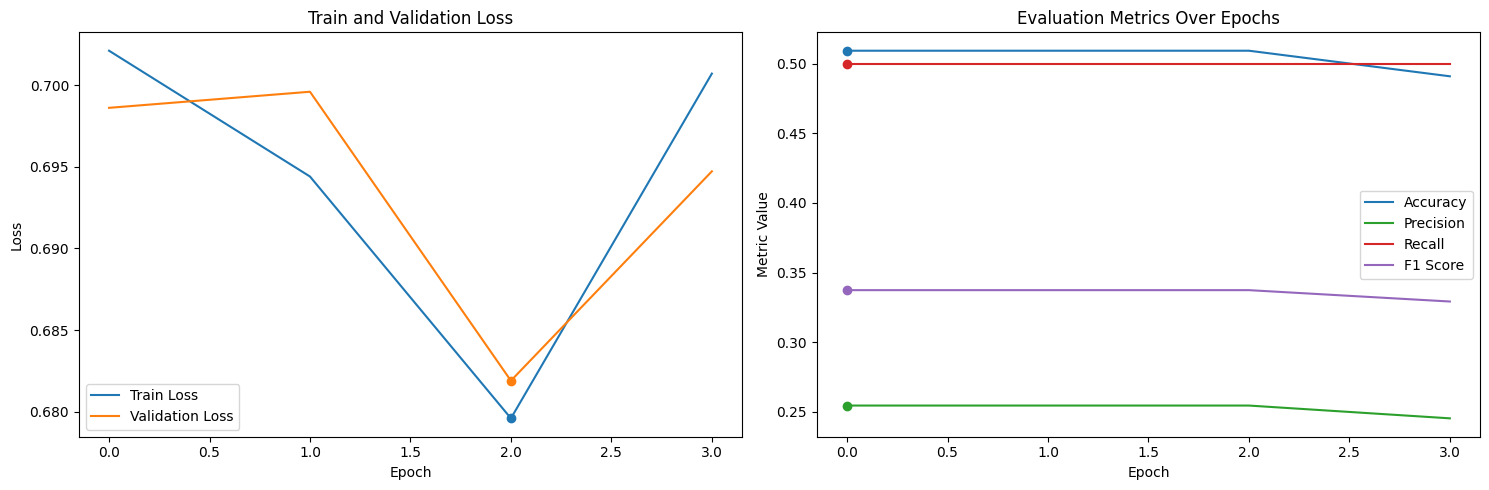

In [64]:
plot_train_eval_metrics(distilliation_trainer_pruned, all_metrics_pruned_distilled)

In [33]:
# Pruned model path with training
pruned_distilled_model_path = "./pruned_distilled_model"

In [35]:
# Save pruned model with training
distilliation_trainer_pruned.save_model(pruned_distilled_model_path)

events.out.tfevents.1735169992.AirvonChristoph.fritz.box.5582.2:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

In [36]:
pruned_distilled_model = load_local_model(pruned_distilled_model_path, set_size=True)

#### Tiny Bert

In [37]:
distilliation_trainer_tiny_bert.train()

all_metrics_tiny_bert_distilled = all_metrics

all_metrics = []

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.689100,0.700185,0.509174,0.254587,0.500000,0.337386
2,0.685600,0.694963,0.509174,0.504598,0.500042,0.339464
3,0.680600,0.691415,0.521789,0.582408,0.513398,0.388595
4,0.679700,0.689490,0.526376,0.567296,0.518576,0.416068
5,0.673200,0.686268,0.529817,0.539445,0.524101,0.475765
6,0.668000,0.683904,0.557339,0.570715,0.552728,0.524856
7,0.667100,0.681898,0.575688,0.581327,0.572725,0.562750
8,0.663500,0.680233,0.581422,0.588375,0.578355,0.567765
9,0.663800,0.679294,0.577982,0.582005,0.575398,0.568084
10,0.659100,0.679002,0.575688,0.578827,0.573272,0.566931


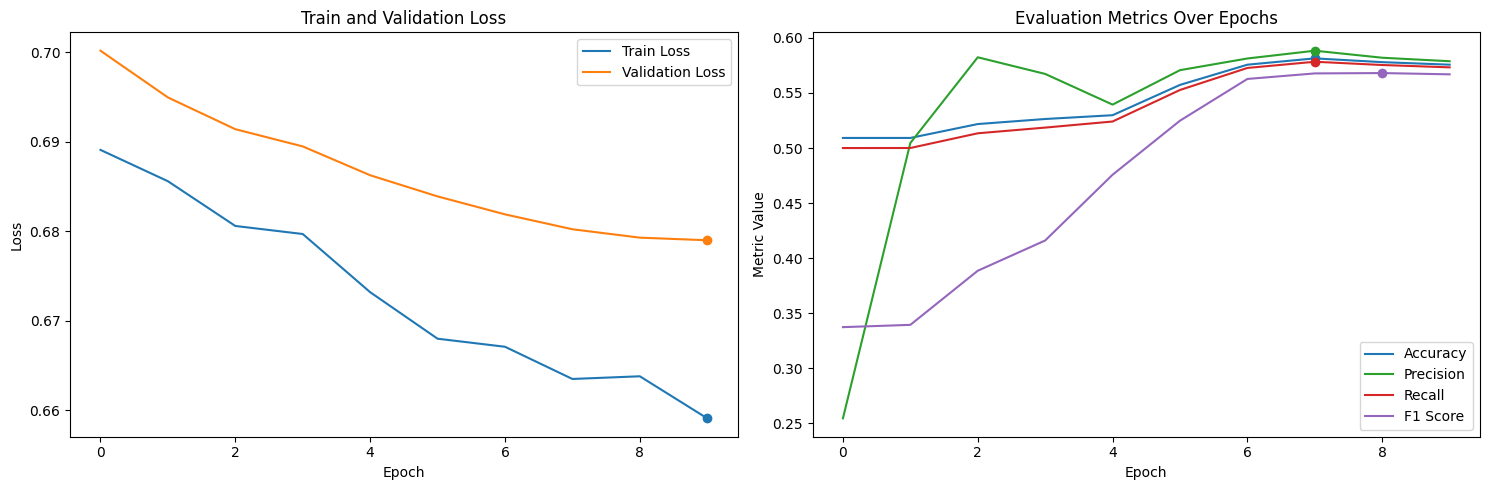

In [38]:
plot_train_eval_metrics(distilliation_trainer_tiny_bert, all_metrics_tiny_bert_distilled)

In [39]:
# Pruned model path with training
tiny_bert_distilled_model_path = "./tiny_bert_distilled_model"

In [40]:
# Save pruned model with training
distilliation_trainer_tiny_bert.save_model(tiny_bert_distilled_model_path)

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

events.out.tfevents.1735170159.AirvonChristoph.fritz.box.5582.3:   0%|          | 0.00/12.2k [00:00<?, ?B/s]

In [41]:
tiny_bert_distilled_model = load_local_model(tiny_bert_distilled_model_path)

## Hyperparameter Search for Distillation parameter `alpha` & `temperature` with optuna

In [ ]:
#%pip install optuna

In [42]:
n_trials=3
direction="maximize"

def hp_space(trial):
    return {
      "num_train_epochs": trial.suggest_int("num_train_epochs", 3, 10),
      "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-3 ,log=True),
      "alpha": trial.suggest_float("alpha", 0, 1),
      "temperature": trial.suggest_int("temperature", 2, 30),
      }

In [43]:
def student_init_pruned_distilled():
    return load_local_model(pruned_distilled_model_path, set_size=True) # We don't want to override the model during hyperparameter exploration

def student_init_tiny_bert_distilled():
    return load_local_model(tiny_bert_distilled_model_path) # We don't want to override the model during hyperparameter exploration

pruned_distilled_trainer_exploration = DistillationTrainer(
    model_init=student_init_pruned_distilled,
    args=training_args,
    teacher_model=teacher_model,
    train_dataset=tokenized_datasets["train"],#.select(range(1000)),
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    accelerator=accelerator
)

tiny_bert_distilled_trainer_exploration = DistillationTrainer(
    model_init=student_init_tiny_bert_distilled,
    args=training_args,
    teacher_model=teacher_model,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    accelerator=accelerator
)

/var/folders/mv/96db_j8j3ng3t9pc8jczncdh0000gn/T/ipykernel_5582/239319299.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


#### Pruned Model

In [44]:
best_run_pruned = pruned_distilled_trainer_exploration.hyperparameter_search(
    n_trials=n_trials,
    direction=direction,
    hp_space=hp_space
)
print(best_run_pruned)

[I 2024-12-26 00:43:37,058] A new study created in memory with name: no-name-3989c764-c738-407f-b830-e381802107b7


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.463200,0.582731,0.729358,0.730407,0.729898,0.729288
2,0.399500,0.756129,0.706422,0.720608,0.703966,0.699957
3,0.364000,0.679148,0.721330,0.727841,0.719658,0.718262
4,0.312500,0.639595,0.722477,0.722722,0.722005,0.722055
5,0.292000,0.625351,0.739679,0.743217,0.740707,0.739209
6,0.290300,0.699409,0.722477,0.723669,0.721668,0.721562
7,0.256400,0.720346,0.716743,0.718471,0.715785,0.715528


[I 2024-12-26 00:45:15,881] Trial 0 finished with value: 2.8665268995275097 and parameters: {'num_train_epochs': 7, 'learning_rate': 2.4409731600070814e-05, 'alpha': 0.8671642087600091, 'temperature': 11}. Best is trial 0 with value: 2.8665268995275097.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.718000,0.692659,0.509174,0.254587,0.500000,0.337386
2,0.686300,0.691742,0.533257,0.639180,0.524954,0.406490
3,0.565400,0.603923,0.713303,0.713818,0.713669,0.713289
4,0.332000,0.793123,0.733945,0.735417,0.733098,0.732995
5,0.199000,0.895016,0.642202,0.727180,0.647680,0.610159
6,0.156400,1.014767,0.735092,0.765864,0.738139,0.728782
7,0.131700,0.885722,0.735092,0.736666,0.734224,0.734109
8,0.083000,0.873520,0.737385,0.741994,0.736013,0.735322
9,0.062100,0.903806,0.735092,0.737717,0.734013,0.733702


[I 2024-12-26 00:49:02,278] Trial 1 finished with value: 2.940523930104619 and parameters: {'num_train_epochs': 9, 'learning_rate': 0.0004920084520902496, 'alpha': 0.7678755615406611, 'temperature': 16}. Best is trial 1 with value: 2.940523930104619.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.627200,0.593896,0.688073,0.723088,0.691589,0.677760
2,0.438300,0.783691,0.706422,0.722944,0.703797,0.699103
3,0.336800,0.597039,0.723624,0.741620,0.726036,0.719713
4,0.259700,0.711457,0.724771,0.726322,0.723878,0.723711
5,0.200400,0.722185,0.725917,0.728395,0.724836,0.724479
6,0.166300,0.822534,0.715596,0.724032,0.713690,0.711651
7,0.121400,0.855530,0.732798,0.733038,0.732350,0.732415
8,0.101200,0.927158,0.728211,0.728363,0.727804,0.727867
9,0.124800,1.046015,0.716743,0.724213,0.714943,0.713194


[I 2024-12-26 00:52:50,538] Trial 2 finished with value: 2.869093028671804 and parameters: {'num_train_epochs': 9, 'learning_rate': 6.014304501030931e-05, 'alpha': 0.30591788794505836, 'temperature': 14}. Best is trial 1 with value: 2.940523930104619.


BestRun(run_id='1', objective=2.940523930104619, hyperparameters={'num_train_epochs': 9, 'learning_rate': 0.0004920084520902496, 'alpha': 0.7678755615406611, 'temperature': 16}, run_summary=None)


#### Tiny Bert

In [45]:
best_run_tiny_bert = tiny_bert_distilled_trainer_exploration.hyperparameter_search(
    n_trials=n_trials,
    direction=direction,
    hp_space=hp_space
)
print(best_run_tiny_bert)

[I 2024-12-26 00:52:50,559] A new study created in memory with name: no-name-1f340c7b-1c1d-4e5e-b7f3-d324748ba9fd


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.657300,0.640244,0.652523,0.652385,0.652301,0.652321
2,0.572800,0.597326,0.676606,0.703247,0.673129,0.662872
3,0.454500,0.574362,0.702982,0.714067,0.700756,0.697536
4,0.356900,0.642000,0.691514,0.723903,0.687895,0.677301
5,0.275200,0.573616,0.741972,0.742110,0.742159,0.741969
6,0.221800,0.631164,0.721330,0.727125,0.719742,0.718528
7,0.202700,0.618778,0.729358,0.730041,0.728719,0.728728


[I 2024-12-26 00:55:04,494] Trial 0 finished with value: 2.9168469353535467 and parameters: {'num_train_epochs': 7, 'learning_rate': 0.0003159449637001279, 'alpha': 0.5098641163454418, 'temperature': 6}. Best is trial 0 with value: 2.9168469353535467.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.660900,0.664551,0.620413,0.622617,0.618833,0.616771
2,0.633500,0.647386,0.643349,0.643419,0.643460,0.643337
3,0.601600,0.625557,0.666284,0.669240,0.667330,0.665616
4,0.560900,0.600376,0.676606,0.676687,0.676118,0.676113
5,0.529100,0.584066,0.692661,0.693257,0.693062,0.692635
6,0.498400,0.582325,0.696101,0.702326,0.694336,0.692451
7,0.471200,0.566080,0.709862,0.709769,0.709786,0.709777
8,0.444100,0.565376,0.701835,0.702458,0.701145,0.701074
9,0.428900,0.567106,0.705275,0.707840,0.704102,0.703525
10,0.427100,0.566145,0.704128,0.705964,0.703103,0.702721


[I 2024-12-26 00:55:26,779] Trial 1 finished with value: 2.81591603205056 and parameters: {'num_train_epochs': 10, 'learning_rate': 9.747851872707344e-05, 'alpha': 0.24223036785559338, 'temperature': 26}. Best is trial 0 with value: 2.9168469353535467.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.657900,0.645195,0.633028,0.634878,0.631641,0.630219
2,0.588600,0.609668,0.669725,0.678791,0.667467,0.663564
3,0.523000,0.585171,0.700688,0.704560,0.701829,0.699958


[I 2024-12-26 00:55:43,923] Trial 2 finished with value: 2.807035833193967 and parameters: {'num_train_epochs': 3, 'learning_rate': 0.00030777022977852993, 'alpha': 0.30324667926776516, 'temperature': 26}. Best is trial 0 with value: 2.9168469353535467.


BestRun(run_id='0', objective=2.9168469353535467, hyperparameters={'num_train_epochs': 7, 'learning_rate': 0.0003159449637001279, 'alpha': 0.5098641163454418, 'temperature': 6}, run_summary=None)


In [66]:
# overwrite initial hyperparameters with from the best_run
for k,v in best_run_pruned.hyperparameters.items():
    setattr(training_args, k, v)

# Create a new Trainer with optimal parameters
pruned_ts_distillation_trainer = DistillationTrainer(
    pruned_distilled_model,
    training_args,
    teacher_model=teacher_model,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/var/folders/mv/96db_j8j3ng3t9pc8jczncdh0000gn/T/ipykernel_5582/239319299.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


#### Pruned Model

In [67]:
pruned_ts_distillation_trainer.train()

all_metrics_pruned_ts_distillation = all_metrics

all_metrics = []

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.734800,0.693324,0.509174,0.254587,0.500000,0.337386
2,0.703500,0.695699,0.509174,0.254587,0.500000,0.337386
3,0.695000,0.693446,0.509174,0.254587,0.500000,0.337386
4,0.689300,0.705961,0.509174,0.254587,0.500000,0.337386
5,0.691400,0.701048,0.509174,0.254587,0.500000,0.337386
6,0.688300,0.696628,0.509174,0.254587,0.500000,0.337386
7,0.687300,0.695959,0.509174,0.254587,0.500000,0.337386
8,0.688300,0.699201,0.509174,0.254587,0.500000,0.337386
9,0.686900,0.699105,0.509174,0.254587,0.500000,0.337386


In [ ]:
plot_train_eval_metrics(pruned_ts_distillation_trainer, all_metrics_pruned_ts_distillation)

In [ ]:
# Pruned model path with training
pruned_model_ts_destillation_path = "./pruned_model_ts_destilled"

In [ ]:
# Save pruned model with training
prune_trainer.save_model(pruned_model_ts_destillation_path)

In [ ]:
pruned_ts_distilled_model = load_local_model(pruned_model_ts_destillation_path, set_size=True)

#### Tiny Bert

In [ ]:
for k,v in best_run_tiny_bert.hyperparameters.items():
    setattr(training_args, k, v)

tiny_bert_ts_distilliation_trainer = DistillationTrainer(
    tiny_bert_distilled_model,
    training_args,
    teacher_model=teacher_model,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [49]:
tiny_bert_ts_distilliation_trainer.train()

all_metrics_tiny_bert_ts_distillation = all_metrics

all_metrics = []

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.651400,0.632274,0.678899,0.686155,0.680559,0.676934
2,0.548300,0.569402,0.717890,0.732776,0.720110,0.714573
3,0.416200,0.559636,0.720183,0.723656,0.718910,0.718263
4,0.318900,0.577160,0.737385,0.737562,0.736981,0.737053
5,0.247700,0.599839,0.736239,0.736533,0.735771,0.735837
6,0.213800,0.619560,0.740826,0.741051,0.740402,0.740476
7,0.177600,0.637553,0.735092,0.736487,0.734266,0.734182


In [ ]:
plot_train_eval_metrics(tiny_bert_ts_distillation_trainer, all_metrics_tiny_bert_ts_distillation)

In [ ]:
# Pruned model path with training
tiny_bert_model_ts_destillation_path = "./tiny_bert_model_ts_destilled"

In [ ]:
# Save pruned model with training
prune_trainer.save_model(tiny_bert_model_ts_destillation_path)

In [ ]:
tiny_bert_ts_distilled_model = load_local_model(tiny_bert_model_ts_destillation_path)

## Evaluation TODO: CHANGE ALL MODEL NAMES TO THE REAL ONES

In [ ]:
val_data = load_dataset("glue","sst2", split="validation")

# Run all models on cpu for comparability
pruned_model_trained = pruned_model_trained.to("cpu")
pruned_distilled_model_trained = pruned_distilled_model_trained.to("cpu")
tiny_bert_model = tiny_bert_model.to("cpu")
tiny_bert_distilled_model = tiny_bert_distilled_model.to("cpu")
teacher_model = teacher_model.to("cpu")

pruned_model_eval = evaluate_model(pruned_model_trained, tokenizer, val_data)
pruned_distilled_model_eval = evaluate_model(pruned_distilled_model_trained, tokenizer, val_data)

tiny_bert_model.config.id2label = {0: 'negative', 1: 'positive'}
tiny_bert_model.config.label2id = {'negative': 0, 'positive': 1}
tiny_bert_model_eval = evaluate_model(tiny_bert_model, tokenizer, val_data)
tiny_bert_distilled_model_eval = evaluate_model(tiny_bert_distilled_model, tokenizer, val_data)

teacher_model.config.id2label = {0: 'negative', 1: 'positive'}
teacher_model.config.label2id = {'negative': 0, 'positive': 1}
teacher_model_eval = evaluate_model(teacher_model, tokenizer, val_data)

# Visualize Results

In [ ]:
from IPython.display import display, HTML

model_results = {
    'Pruned': pruned_model_eval,
    'Pruned + Disitlled': pruned_distilled_model_eval,
    'Tiny Bert': tiny_bert_model_eval,
    'Tiny Bert + Distilled': tiny_bert_distilled_model_eval,
    'Bert': teacher_model_eval
}

# Create HTML table structure
html_table = '<table border="1" style="border-collapse: collapse;">'

# Add header row
html_table += '<thead><tr><th style="padding: 5px; background-color: #f0f0f0; text-align: center;">Metric</th>'
for model_name in model_results.keys():
    html_table += f'<th style="padding: 5px; background-color: #f0f0f0; text-align: center;">{model_name}</th>'
html_table += '</tr></thead><tbody>'

# Add rows for each metric
metrics = list(next(iter(model_results.values())).keys())  # Extract metric names
for metric in metrics:
    html_table += f'<tr><td style="padding: 5px; text-align: left; background-color: #f9f9f9;">{metric}</td>'
    for model_name in model_results.keys():
        value = round(model_results[model_name][metric], 4)
        html_table += f'<td style="padding: 5px; text-align: center;">{value}</td>'
    html_table += '</tr>'

# Close the table
html_table += '</tbody></table>'

# Display the table
display(HTML(html_table))


In [ ]:
# Visualization
import matplotlib.pyplot as plt
import numpy as np

model_results = {
    'pruned_model': pruned_model_eval,
    'pruned_distilled_model': pruned_distilled_model_eval,
    'tiny_bert_model': tiny_bert_model_eval,
    'tiny_bert_distilled_model': tiny_bert_distilled_model_eval,
    'teacher_model': teacher_model_eval
}

model_names = list(model_results.keys())
metrics = list(model_results[model_names[0]].keys())

# Create a plot for each metric
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Loop over each metric and plot
for i, metric in enumerate(metrics):
    ax = axs[i // 2, i % 2]
    values = [model_results[model][metric] for model in model_names]
    best_value = max(values) if metric != 'total_time_in_seconds' and metric != 'latency_in_seconds' else min(values)
    best_model = model_names[values.index(best_value)]

    # Create a bar chart
    bars = ax.bar(model_names, values, color='lightblue')

    # Mark the best bar
    for bar in bars:
        if bar.get_height() == best_value:
            bar.set_color('orange')

    # Add labels and title
    ax.set_title(f'{metric} for Each Model')
    ax.set_ylabel(metric)
    ax.set_xticks(range(len(model_names))) # because of warning
    ax.set_xticklabels(model_names, rotation=45, ha="right")
    
    # Highlight the best model with a label
    ax.text(best_model, best_value, f'Best: {best_model}', color='black', ha='center', va='bottom', fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()


# Compare Performance on test prompts

In [ ]:
# HTML, because I could'nt find a good package that has colspan functionality
from transformers import pipeline
import torch
from IPython.display import display, HTML

models = [
    {"model": pruned_model_trained, "tokenizer": tokenizer, "label": "Pruned"},
    {"model": pruned_distilled_model_trained, "tokenizer": tokenizer, "label": "Pruned + Distilled"},
    {"model": tiny_bert_model, "tokenizer": tokenizer, "label": "Tiny Bert"},
    {"model": tiny_bert_distilled_model, "tokenizer": tokenizer, "label": "Tiny Bert + Distilled"},
    {"model": teacher_model, "tokenizer": tokenizer, "label": "Bert"}
    # Add more models as needed
]

# Initialize the classifier pipelines for each model
device = torch.device("cpu")

# Use 'pipeline' properly to initialize each model's text classification pipeline
pipelines = [
    pipeline("text-classification", model=model_info["model"], tokenizer=model_info["tokenizer"], device=-1)
    for model_info in models
]

# Assuming you have a list of prompts
prompts = [
    "This movie was amazing!",
    "I hated the ending.",
    "The acting was mediocre.",
    "It was an okay film.",
    "A truly captivating experience!",
    "The movie wasn't good. It was great!"
]

# Create the HTML table structure for model results
model_results_html = '<table border="1" style="border-collapse: collapse;">'  # Table with borders collapsed

model_results_html += '<thead><tr><th  style="border: 1px solid black;background-color: #d3d3d3"></th>'  # First header cell

# Add headers for each model's label and score, with borders
for model in models:
    model_results_html += f'<th colspan="2" style="border: 1px solid black; text-align: center;background-color: #d3d3d3">{model["label"]}</th>'
model_results_html += '</tr><tr>'

model_results_html += '<th style="border: 1px solid black;text-align: center;background-color: #d3d3d3">Prompt</th>'  # Prompt header cell

# Add "Label" and "Score" headers for each model, with borders
for model in models:
    model_results_html += '<th style="border: 1px solid black;text-align: center;background-color: #d3d3d3">Label</th>'
    model_results_html += '<th style="border: 1px solid black;text-align: center;background-color: #d3d3d3">Score</th>'
model_results_html += '</tr></thead><tbody>'

# Process each prompt for all models and add to the HTML table
for prompt in prompts:
    model_results_html += f'<tr><td style="border: 1px solid black;">{prompt}</td>'  # Add borders for the Prompt cell
    
    for pipeline in pipelines:
        result = pipeline(prompt)[0]
        label = result['label']
        
        # Map the label to 1 (positive) or 0 (negative)
        if label == "positive":
            label = "1"  # Convert to string
        elif label == "negative":
            label = "0"  # Convert to string
        
        score = f"{result['score']:.4f}"
        model_results_html += f'<td style="border: 1px solid black;text-align: center">{label}</td>'  # Add borders for the Label column
        model_results_html += f'<td style="border: 1px solid black;text-align: center">{score}</td>'  # Add borders for the Score column
    
    model_results_html += '</tr>'

# Close the table tag
model_results_html += '</tbody></table>'

# Display the final HTML table with only model results
display(HTML(model_results_html))


### Huggingface

In [ ]:
# save best model, metrics and create model card
trainer.create_model_card(model_name=training_args.hub_model_id)
trainer.push_to_hub()

In [ ]:
from huggingface_hub import HfApi

whoami = HfApi().whoami()
username = whoami['name']

print(f"https://huggingface.co/{username}/{repo_name}")